In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-dataset/breast-cancer.csv


In [5]:
# 📌 Support Vector Machines (SVM) - Binary Classification (Breast Cancer Dataset)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_decision_regions

In [6]:
# 1️⃣ Load Dataset
DATA_PATH = os.path.join("/kaggle", "input", "breast-cancer-dataset", "breast-cancer.csv")
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at '{DATA_PATH}'. Please download breast cancer CSV and place it there.")
df = pd.read_csv(DATA_PATH)
print(df.head())

# Drop 'id' column (not useful)
df.drop(columns=['id'], inplace=True)

# Encode 'diagnosis' -> M=1, B=0
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])

# Features (X) and Labels (y)
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [7]:
# 2️⃣ Train SVM (Linear Kernel)
svm_linear = SVC(kernel="linear", C=1)
svm_linear.fit(X_train, y_train)

y_pred_linear = svm_linear.predict(X_test)
print("🔹 Linear Kernel Accuracy:", accuracy_score(y_test, y_pred_linear))

🔹 Linear Kernel Accuracy: 0.956140350877193


In [9]:
# 3️⃣ Train SVM (RBF Kernel)
svm_rbf = SVC(kernel="rbf", C=1, gamma=0.1)
svm_rbf.fit(X_train, y_train)

y_pred_rbf = svm_rbf.predict(X_test)
print("🔹 RBF Kernel Accuracy:", accuracy_score(y_test, y_pred_rbf))

🔹 RBF Kernel Accuracy: 0.9649122807017544


In [10]:
# 4️⃣ Hyperparameter Tuning (GridSearchCV)
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001],
    "kernel": ["rbf"]
}

grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("\n✅ Best Parameters:", grid.best_params_)
print("✅ Best CV Score:", grid.best_score_)

# Test best model
best_svm = grid.best_estimator_
y_pred_best = best_svm.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))


✅ Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
✅ Best CV Score: 0.9736263736263737

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Confusion Matrix:
 [[71  0]
 [ 2 41]]


In [11]:
# 5️⃣ Cross-validation score for reliability
scores = cross_val_score(best_svm, X_scaled, y, cv=5)
print("\n📊 Cross-Validation Accuracy: %.2f%%" % (scores.mean() * 100))


📊 Cross-Validation Accuracy: 97.89%


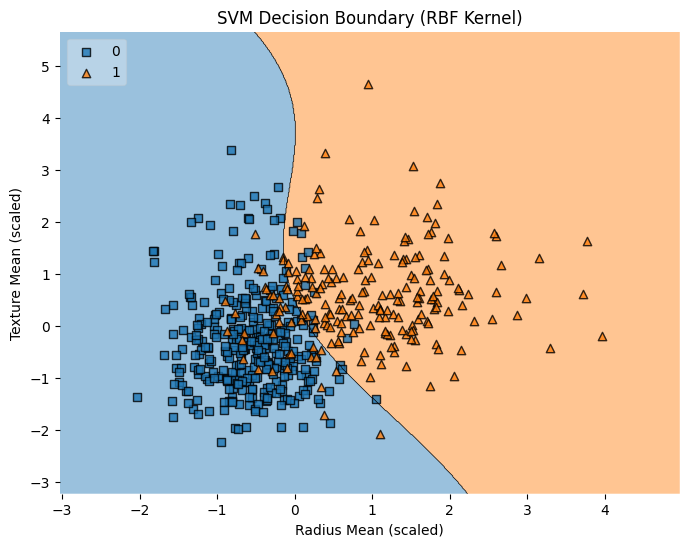

In [12]:
# 6️⃣ Visualize Decision Boundary (using 2D subset for visualization)
# Taking only 2 features: radius_mean, texture_mean
X_vis = df[['radius_mean', 'texture_mean']].values
y_vis = df['diagnosis'].values
X_vis = StandardScaler().fit_transform(X_vis)

svm_vis = SVC(kernel="rbf", C=1, gamma=0.1)
svm_vis.fit(X_vis, y_vis)

plt.figure(figsize=(8,6))
plot_decision_regions(X_vis, y_vis, clf=svm_vis, legend=2)
plt.xlabel("Radius Mean (scaled)")
plt.ylabel("Texture Mean (scaled)")
plt.title("SVM Decision Boundary (RBF Kernel)")
plt.show()